In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import concatenate
from math import sqrt
from statistics import mean
import random
import matplotlib.pyplot as plt

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/Users/alexellard/Downloads/scenarios_data.csv', header=0, index_col=0)
df

,reservoir_demand,node_1_demand,node_2_demand,node_3_demand,node_4_demand,node_5_demand,node_6_demand,node_7_demand,node_8_demand,node_9_demand,...,link_23_flow,link_24_flow,link_25_flow,link_26_flow,link_27_flow,link_28_flow,link_29_flow,link_30_flow,link_31_flow,link_32_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-3348.0,154.8,169.2,18.0,118.8,169.2,234.0,86.4,82.8,104.4,...,439.2,-205.2,-75.6,-18.0,118.8,68.4,7.2,-54.0,75.6,212.4
2017-01-01 00:30:00,-2959.2,136.8,147.6,18.0,108.0,144.0,237.6,79.2,75.6,90.0,...,392.4,-187.2,-72.0,-21.6,108.0,61.2,3.6,-54.0,72.0,183.6
2017-01-01 01:00:00,-2692.8,129.6,126.0,14.4,104.4,133.2,205.2,72.0,72.0,90.0,...,349.2,-176.4,-64.8,-18.0,93.6,50.4,3.6,-39.6,54.0,151.2
2017-01-01 01:30:00,-2379.6,104.4,100.8,10.8,86.4,122.4,180.0,68.4,57.6,82.8,...,316.8,-158.4,-54.0,-10.8,79.2,46.8,7.2,-32.4,50.4,140.4
2017-01-01 02:00:00,-2228.4,104.4,104.4,10.8,79.2,122.4,183.6,68.4,54.0,75.6,...,277.2,-144.0,-57.6,-18.0,72.0,39.6,7.2,-32.4,43.2,118.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,-5306.4,205.2,208.8,39.6,183.6,284.4,316.8,176.4,133.2,129.6,...,604.8,-259.2,32.4,115.2,169.2,100.8,10.8,-100.8,122.4,309.6
2017-12-31 22:00:00,-4910.4,208.8,183.6,39.6,154.8,252.0,295.2,165.6,133.2,133.2,...,565.2,-241.2,21.6,100.8,154.8,86.4,18.0,-75.6,100.8,288.0
2017-12-31 22:30:00,-4683.6,187.2,183.6,36.0,147.6,230.4,320.4,147.6,118.8,126.0,...,529.2,-226.8,21.6,100.8,147.6,86.4,14.4,-86.4,108.0,266.4


In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, vars_to_predict=None):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i-1))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(n_out):
        cols.append(df[vars_to_predict].shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in vars_to_predict]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in vars_to_predict]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

# node 1 indexes
target_variable_demand_node1 = [1]
target_variable_pressures_node1 = [33]
target_variable_flows_node1 = [64]
#node 16 indexes
target_variable_demand_node16 = [16]
target_variable_pressures_node16 = [48]
target_variable_flows_node16 = [79]
#node 29 indexes
target_variable_demand_node29 = [29]
target_variable_pressures_node29 = [61]
target_variable_flows_node29 = [92]


reframed_demand_node1 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node1)
reframed_pressures_node1 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node1)
reframed_flows_node1 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_flows_node1)

reframed_demand_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node16)
reframed_pressures_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node16)
reframed_flows_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_flows_node16)

reframed_demand_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node29)
reframed_pressures_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node29)
reframed_flows_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_flows_node29)

reframed_demand_node1 = reframed_demand_node1.drop(reframed_demand_node1.columns[1], axis=1)
reframed_pressures_node1 = reframed_pressures_node1.drop(reframed_pressures_node1.columns[33], axis=1)
reframed_flows_node1 = reframed_flows_node1.drop(reframed_flows_node1.columns[64], axis=1)

reframed_demand_node16 = reframed_demand_node16.drop(reframed_demand_node16.columns[16], axis=1)
reframed_pressures_node16 = reframed_pressures_node16.drop(reframed_pressures_node16.columns[48], axis=1)
reframed_flows_node16 = reframed_flows_node16.drop(reframed_flows_node16.columns[79], axis=1)

reframed_demand_node29 = reframed_demand_node29.drop(reframed_demand_node29.columns[29], axis=1)
reframed_pressures_node29 = reframed_pressures_node29.drop(reframed_pressures_node29.columns[61], axis=1)
reframed_flows_node29 = reframed_flows_node29.drop(reframed_flows_node29.columns[92], axis=1)

In [ ]:
#Run pressure node 29

MAE_average = []
RMSE_average = []
R2_average = []
maximum_MAE = []
sensors_covered = []
n_columns_to_drop = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
for n in n_columns_to_drop:
    MAE = []
    RMSE = []
    R2 = []
    for run in range(1,11):
        values = df.values
        values = values.astype('float32')
        reframed_pressures_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node29)
        reframed_pressures_node29 = reframed_pressures_node29.drop(reframed_pressures_node29.columns[61], axis=1)
        #select random columns to drop
        columns_to_drop = random.sample(list(reframed_pressures_node29.columns), n)
        # Drop the selected columns from the dataframe
        if reframed_pressures_node29.columns[-1] in columns_to_drop:
            columns_to_drop.remove(reframed_pressures_node29.columns[-1])
        reframed_pressures_node29.drop(columns_to_drop, axis=1, inplace=True)
        print('starting df shape:', reframed_pressures_node29.shape)
        print(f'This is training run {run} and has the shape: ', reframed_pressures_node29.shape)
        print(f'The value of dropped columns is {n}')

        # split into train and test sets
        values = reframed_pressures_node29.values
        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        print('test y shape :', test_y.shape)
        inv_test_y = concatenate((test_y, test_X[:, -reframed_pressures_node29.shape[1]:]), axis=1)
        print('Inv y shape :', inv_test_y.shape)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]

        y_pred = y_pred.reshape((len(y_pred), 1))
        print('y pred shape :', y_pred.shape)
        inv_y_pred = concatenate((y_pred, test_X[:, -reframed_pressures_node29.shape[1]:]), axis=1)
        print('inv y pred :', inv_y_pred.shape)
        y_pred_inverse = scaler.inverse_transform(inv_y_pred)
        y_pred_inverse = y_pred_inverse[:,0]

        # evaluate scaled errors
        mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
        MAE.append(mae_inverse)
        print(f'Run {run} Mean Absolute Error:', mae_inverse)
        rmse_inverse = sqrt(mean_squared_error(test_y_inverse, y_pred_inverse))
        RMSE.append(rmse_inverse)
        print('RMSE: %.3f' % rmse_inverse)
        r2_inverse = r2_score(test_y_inverse, y_pred_inverse)
        R2.append(r2_inverse)
        print('R^2: %.3f' % r2_inverse)
    percentage_list = round(reframed_pressures_node29.shape[1] / 96 * 100)
    sensors_covered.append(percentage_list)
    MAE_mean = mean(MAE)
    RMSE_mean = mean(RMSE)
    R2_mean = mean(R2)
    max_MAE = max(MAE)
    maximum_MAE.append(max_MAE)
    MAE_average.append(MAE_mean)
    RMSE_average.append(RMSE_mean)
    R2_average.append(R2_mean)
print('Length MAE_average: ', len(MAE_average))
print('Length sensors_covered: ', len(sensors_covered))

starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 1 Mean Absolute Error: 2.7317557
RMSE: 3.920
R^2: 1.000
starting df shape: (87600, 96)
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 2 Mean Absolute Error: 2.7317557
RMSE: 3.920
R^2: 1.000
starting df shape: (87600, 96)
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 3 Mean Absolute Error: 2.7317557
RMSE: 3.920
R^2: 1.000
starting df shape: (87600, 96)
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 4 Mean Absolute Error: 2.7317557
RMSE: 3.920
R^2: 1.000
starting df shape: (87600, 96)
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 5 Mean Absolute Error: 2.7317557
RMSE: 3.920
R^2: 1.000
starting df shape: (87600, 96)
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 6 Mean Absolute Error: 2.7317557
RMSE: 3.920
R^2: 1.000
starting df shape: (87600, 96)
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 7 Mean Absolute Error: 2.7317557
RMSE: 3.920
R^2: 1.000
starting df shape: (87600, 96)
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 8 Mean Absolute Error: 2.7317557
RMSE: 3.920
R^2: 1.000
starting df shape: (87600, 96)
This is training run 9 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 9 Mean Absolute Error: 2.7317557
RMSE: 3.920
R^2: 1.000
starting df shape: (87600, 96)
This is training run 10 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 10 Mean Absolute Error: 2.7317557
RMSE: 3.920
R^2: 1.000
starting df shape: (87600, 91)
This is training run 1 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 1 Mean Absolute Error: 2.7178552
RMSE: 3.942
R^2: 1.000
starting df shape: (87600, 92)
This is training run 2 and has the shape:  (87600, 92)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 92)
y pred shape : (17520, 1)
inv y pred : (17520, 92)
Run 2 Mean Absolute Error: 2.9634624
RMSE: 4.241
R^2: 1.000
starting df shape: (87600, 91)
This is training run 3 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 3 Mean Absolute Error: 2.8447807
RMSE: 4.070
R^2: 1.000
starting df shape: (87600, 91)
This is training run 4 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 4 Mean Absolute Error: 3.1987598
RMSE: 4.504
R^2: 1.000
starting df shape: (87600, 92)
This is training run 5 and has the shape:  (87600, 92)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 92)
y pred shape : (17520, 1)
inv y pred : (17520, 92)
Run 5 Mean Absolute Error: 2.8429296
RMSE: 4.188
R^2: 1.000
starting df shape: (87600, 91)
This is training run 6 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 6 Mean Absolute Error: 2.7207167
RMSE: 3.965
R^2: 1.000
starting df shape: (87600, 91)
This is training run 7 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 7 Mean Absolute Error: 2.811604
RMSE: 4.021
R^2: 1.000
starting df shape: (87600, 91)
This is training run 8 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 8 Mean Absolute Error: 3.9673307
RMSE: 5.423
R^2: 1.000
starting df shape: (87600, 91)
This is training run 9 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 9 Mean Absolute Error: 2.7054477
RMSE: 3.918
R^2: 1.000
starting df shape: (87600, 91)
This is training run 10 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 10 Mean Absolute Error: 2.832927
RMSE: 4.050
R^2: 1.000
starting df shape: (87600, 86)
This is training run 1 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 1 Mean Absolute Error: 3.4484458
RMSE: 4.875
R^2: 1.000
starting df shape: (87600, 86)
This is training run 2 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 2 Mean Absolute Error: 2.7447648
RMSE: 3.934
R^2: 1.000
starting df shape: (87600, 86)
This is training run 3 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 3 Mean Absolute Error: 3.356641
RMSE: 4.763
R^2: 1.000
starting df shape: (87600, 87)
This is training run 4 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)
y pred shape : (17520, 1)
inv y pred : (17520, 87)
Run 4 Mean Absolute Error: 3.0717664
RMSE: 4.411
R^2: 1.000
starting df shape: (87600, 86)
This is training run 5 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 5 Mean Absolute Error: 3.1385863
RMSE: 4.613
R^2: 1.000
starting df shape: (87600, 86)
This is training run 6 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 6 Mean Absolute Error: 3.2880704
RMSE: 4.734
R^2: 1.000
starting df shape: (87600, 86)
This is training run 7 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 7 Mean Absolute Error: 3.3447773
RMSE: 4.801
R^2: 1.000
starting df shape: (87600, 86)
This is training run 8 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 8 Mean Absolute Error: 3.5494175
RMSE: 5.000
R^2: 1.000
starting df shape: (87600, 86)
This is training run 9 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 9 Mean Absolute Error: 3.128369
RMSE: 4.591
R^2: 1.000
starting df shape: (87600, 86)
This is training run 10 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 10 Mean Absolute Error: 3.4321175
RMSE: 4.897
R^2: 1.000
starting df shape: (87600, 81)
This is training run 1 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 1 Mean Absolute Error: 0.17660159
RMSE: 0.261
R^2: 1.000
starting df shape: (87600, 81)
This is training run 2 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 2 Mean Absolute Error: 2.9435945
RMSE: 4.275
R^2: 1.000
starting df shape: (87600, 81)
This is training run 3 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 3 Mean Absolute Error: 0.18827952
RMSE: 0.267
R^2: 1.000
starting df shape: (87600, 81)
This is training run 4 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 4 Mean Absolute Error: 3.0834353
RMSE: 4.475
R^2: 1.000
starting df shape: (87600, 82)
This is training run 5 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 5 Mean Absolute Error: 2.8991618
RMSE: 4.232
R^2: 1.000
starting df shape: (87600, 81)
This is training run 6 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 6 Mean Absolute Error: 2.8541899
RMSE: 4.146
R^2: 1.000
starting df shape: (87600, 81)
This is training run 7 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 7 Mean Absolute Error: 3.0038712
RMSE: 4.315
R^2: 1.000
starting df shape: (87600, 82)
This is training run 8 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 8 Mean Absolute Error: 2.9392922
RMSE: 4.227
R^2: 1.000
starting df shape: (87600, 82)
This is training run 9 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 9 Mean Absolute Error: 2.7854018
RMSE: 3.989
R^2: 1.000
starting df shape: (87600, 81)
This is training run 10 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 10 Mean Absolute Error: 2.8616893
RMSE: 4.060
R^2: 1.000
starting df shape: (87600, 76)
This is training run 1 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 1 Mean Absolute Error: 2.6599765
RMSE: 3.777
R^2: 1.000
starting df shape: (87600, 76)
This is training run 2 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 2 Mean Absolute Error: 3.0801659
RMSE: 4.348
R^2: 1.000
starting df shape: (87600, 77)
This is training run 3 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 3 Mean Absolute Error: 2.8457055
RMSE: 4.139
R^2: 1.000
starting df shape: (87600, 76)
This is training run 4 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 4 Mean Absolute Error: 3.0336723
RMSE: 4.363
R^2: 1.000
starting df shape: (87600, 76)
This is training run 5 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 5 Mean Absolute Error: 0.17747073
RMSE: 0.256
R^2: 1.000
starting df shape: (87600, 76)
This is training run 6 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 6 Mean Absolute Error: 3.1617455
RMSE: 4.604
R^2: 1.000
starting df shape: (87600, 76)
This is training run 7 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 7 Mean Absolute Error: 2.673628
RMSE: 3.878
R^2: 1.000
starting df shape: (87600, 76)
This is training run 8 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 8 Mean Absolute Error: 2.6806996
RMSE: 3.840
R^2: 1.000
starting df shape: (87600, 76)
This is training run 9 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 9 Mean Absolute Error: 3.034535
RMSE: 4.395
R^2: 1.000
starting df shape: (87600, 76)
This is training run 10 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 10 Mean Absolute Error: 0.17311235
RMSE: 0.241
R^2: 1.000
starting df shape: (87600, 71)
This is training run 1 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 1 Mean Absolute Error: 3.2030814
RMSE: 4.525
R^2: 1.000
starting df shape: (87600, 71)
This is training run 2 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 2 Mean Absolute Error: 0.022618135
RMSE: 0.033
R^2: 1.000
starting df shape: (87600, 71)
This is training run 3 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 3 Mean Absolute Error: 0.21844116
RMSE: 0.303
R^2: 1.000
starting df shape: (87600, 72)
This is training run 4 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 4 Mean Absolute Error: 2.7192874
RMSE: 3.860
R^2: 1.000
starting df shape: (87600, 71)
This is training run 5 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 5 Mean Absolute Error: 3.4322205
RMSE: 4.803
R^2: 1.000
starting df shape: (87600, 71)
This is training run 6 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 6 Mean Absolute Error: 0.17367873
RMSE: 0.257
R^2: 1.000
starting df shape: (87600, 71)
This is training run 7 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 7 Mean Absolute Error: 3.9850297
RMSE: 5.538
R^2: 1.000
starting df shape: (87600, 71)
This is training run 8 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 8 Mean Absolute Error: 3.6347992
RMSE: 5.014
R^2: 1.000
starting df shape: (87600, 71)
This is training run 9 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 9 Mean Absolute Error: 2.8066313
RMSE: 4.014
R^2: 1.000
starting df shape: (87600, 71)
This is training run 10 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 10 Mean Absolute Error: 5.8947096
RMSE: 7.852
R^2: 1.000
starting df shape: (87600, 66)
This is training run 1 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 1 Mean Absolute Error: 0.16359106
RMSE: 0.238
R^2: 1.000
starting df shape: (87600, 66)
This is training run 2 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 2 Mean Absolute Error: 4.156869
RMSE: 5.626
R^2: 1.000
starting df shape: (87600, 66)
This is training run 3 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 3 Mean Absolute Error: 2.8700173
RMSE: 4.088
R^2: 1.000
starting df shape: (87600, 66)
This is training run 4 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 4 Mean Absolute Error: 3.110324
RMSE: 4.402
R^2: 1.000
starting df shape: (87600, 66)
This is training run 5 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 5 Mean Absolute Error: 3.777795
RMSE: 5.299
R^2: 1.000
starting df shape: (87600, 67)
This is training run 6 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 6 Mean Absolute Error: 0.25068355
RMSE: 0.347
R^2: 1.000
starting df shape: (87600, 66)
This is training run 7 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 7 Mean Absolute Error: 3.139187
RMSE: 4.366
R^2: 1.000
starting df shape: (87600, 67)
This is training run 8 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 8 Mean Absolute Error: 4.469335
RMSE: 6.212
R^2: 1.000
starting df shape: (87600, 67)
This is training run 9 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 9 Mean Absolute Error: 3.1626923
RMSE: 4.532
R^2: 1.000
starting df shape: (87600, 66)
This is training run 10 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 10 Mean Absolute Error: 0.033970796
RMSE: 0.048
R^2: 1.000
starting df shape: (87600, 61)
This is training run 1 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 1 Mean Absolute Error: 7.921461
RMSE: 10.764
R^2: 1.000
starting df shape: (87600, 61)
This is training run 2 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 2 Mean Absolute Error: 4.5824265
RMSE: 6.238
R^2: 1.000
starting df shape: (87600, 61)
This is training run 3 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 3 Mean Absolute Error: 4.335868
RMSE: 5.886
R^2: 1.000
starting df shape: (87600, 61)
This is training run 4 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 4 Mean Absolute Error: 3.5838501
RMSE: 4.916
R^2: 1.000
starting df shape: (87600, 61)
This is training run 5 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 5 Mean Absolute Error: 3.4302576
RMSE: 4.859
R^2: 1.000
starting df shape: (87600, 62)
This is training run 6 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 6 Mean Absolute Error: 0.2722447
RMSE: 0.382
R^2: 1.000
starting df shape: (87600, 61)
This is training run 7 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 7 Mean Absolute Error: 3.2637494
RMSE: 4.615
R^2: 1.000
starting df shape: (87600, 62)
This is training run 8 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 8 Mean Absolute Error: 3.2187815
RMSE: 4.586
R^2: 1.000
starting df shape: (87600, 61)
This is training run 9 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 9 Mean Absolute Error: 2.8741138
RMSE: 4.106
R^2: 1.000
starting df shape: (87600, 61)
This is training run 10 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 10 Mean Absolute Error: 5.7870507
RMSE: 7.659
R^2: 1.000
starting df shape: (87600, 56)
This is training run 1 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 1 Mean Absolute Error: 8.08998
RMSE: 10.943
R^2: 1.000
starting df shape: (87600, 57)
This is training run 2 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 2 Mean Absolute Error: 5.964798
RMSE: 8.443
R^2: 1.000
starting df shape: (87600, 57)
This is training run 3 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 3 Mean Absolute Error: 5.2287126
RMSE: 7.339
R^2: 1.000
starting df shape: (87600, 57)
This is training run 4 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 4 Mean Absolute Error: 7.304371
RMSE: 9.714
R^2: 1.000
starting df shape: (87600, 57)
This is training run 5 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 5 Mean Absolute Error: 0.28706017
RMSE: 0.398
R^2: 1.000
starting df shape: (87600, 56)
This is training run 6 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 6 Mean Absolute Error: 0.23693451
RMSE: 0.339
R^2: 1.000
starting df shape: (87600, 56)
This is training run 7 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 7 Mean Absolute Error: 0.038524915
RMSE: 0.054
R^2: 1.000
starting df shape: (87600, 56)
This is training run 8 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 8 Mean Absolute Error: 3.4695585
RMSE: 4.824
R^2: 1.000
starting df shape: (87600, 56)
This is training run 9 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 9 Mean Absolute Error: 4.5420303
RMSE: 6.266
R^2: 1.000
starting df shape: (87600, 56)
This is training run 10 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 10 Mean Absolute Error: 5.763553
RMSE: 8.350
R^2: 1.000
starting df shape: (87600, 51)
This is training run 1 and has the shape:  (87600, 51)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 1 Mean Absolute Error: 2.8578293
RMSE: 4.133
R^2: 1.000
starting df shape: (87600, 52)
This is training run 2 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 2 Mean Absolute Error: 0.028268646
RMSE: 0.039
R^2: 1.000
starting df shape: (87600, 52)
This is training run 3 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 3 Mean Absolute Error: 3.8233252
RMSE: 5.268
R^2: 1.000
starting df shape: (87600, 52)
This is training run 4 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 4 Mean Absolute Error: 3.2679904
RMSE: 4.678
R^2: 1.000
starting df shape: (87600, 52)
This is training run 5 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 5 Mean Absolute Error: 6.3305955
RMSE: 9.000
R^2: 1.000
starting df shape: (87600, 51)
This is training run 6 and has the shape:  (87600, 51)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 6 Mean Absolute Error: 0.245858
RMSE: 0.339
R^2: 1.000
starting df shape: (87600, 51)
This is training run 7 and has the shape:  (87600, 51)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 7 Mean Absolute Error: 7.765919
RMSE: 10.622
R^2: 1.000
starting df shape: (87600, 51)
This is training run 8 and has the shape:  (87600, 51)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 8 Mean Absolute Error: 0.026270848
RMSE: 0.038
R^2: 1.000
starting df shape: (87600, 52)
This is training run 9 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 9 Mean Absolute Error: 0.38473094
RMSE: 0.536
R^2: 1.000
starting df shape: (87600, 52)
This is training run 10 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 10 Mean Absolute Error: 0.45153743
RMSE: 0.608
R^2: 1.000
starting df shape: (87600, 46)
This is training run 1 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 1 Mean Absolute Error: 9.492275
RMSE: 13.040
R^2: 1.000
starting df shape: (87600, 46)
This is training run 2 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 2 Mean Absolute Error: 2.900302
RMSE: 4.114
R^2: 1.000
starting df shape: (87600, 47)
This is training run 3 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 3 Mean Absolute Error: 0.21352659
RMSE: 0.291
R^2: 1.000
starting df shape: (87600, 47)
This is training run 4 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 4 Mean Absolute Error: 0.28916144
RMSE: 0.390
R^2: 1.000
starting df shape: (87600, 47)
This is training run 5 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 5 Mean Absolute Error: 0.16487193
RMSE: 0.232
R^2: 1.000
starting df shape: (87600, 46)
This is training run 6 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 6 Mean Absolute Error: 0.24738714
RMSE: 0.354
R^2: 1.000
starting df shape: (87600, 47)
This is training run 7 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 7 Mean Absolute Error: 8.01109
RMSE: 10.803
R^2: 1.000
starting df shape: (87600, 47)
This is training run 8 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 8 Mean Absolute Error: 3.854717
RMSE: 5.441
R^2: 1.000
starting df shape: (87600, 46)
This is training run 9 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 9 Mean Absolute Error: 0.026005354
RMSE: 0.037
R^2: 1.000
starting df shape: (87600, 46)
This is training run 10 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 10 Mean Absolute Error: 4.254585
RMSE: 5.861
R^2: 1.000
starting df shape: (87600, 41)
This is training run 1 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 1 Mean Absolute Error: 5.4298596
RMSE: 7.902
R^2: 1.000
starting df shape: (87600, 42)
This is training run 2 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 2 Mean Absolute Error: 0.49013788
RMSE: 0.663
R^2: 1.000
starting df shape: (87600, 42)
This is training run 3 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 3 Mean Absolute Error: 0.45579576
RMSE: 0.631
R^2: 1.000
starting df shape: (87600, 42)
This is training run 4 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 4 Mean Absolute Error: 0.29652855
RMSE: 0.415
R^2: 1.000
starting df shape: (87600, 42)
This is training run 5 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 5 Mean Absolute Error: 0.030862078
RMSE: 0.044
R^2: 1.000
starting df shape: (87600, 42)
This is training run 6 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 6 Mean Absolute Error: 5.120368
RMSE: 7.040
R^2: 1.000
starting df shape: (87600, 42)
This is training run 7 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 7 Mean Absolute Error: 6.111914
RMSE: 8.554
R^2: 1.000
starting df shape: (87600, 41)
This is training run 8 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 8 Mean Absolute Error: 4.3249493
RMSE: 5.940
R^2: 1.000
starting df shape: (87600, 42)
This is training run 9 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 9 Mean Absolute Error: 0.28575265
RMSE: 0.401
R^2: 1.000
starting df shape: (87600, 41)
This is training run 10 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 10 Mean Absolute Error: 0.13973992
RMSE: 0.207
R^2: 1.000
starting df shape: (87600, 36)
This is training run 1 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 1 Mean Absolute Error: 3.124863
RMSE: 4.409
R^2: 1.000
starting df shape: (87600, 37)
This is training run 2 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 2 Mean Absolute Error: 6.9314747
RMSE: 10.196
R^2: 1.000
starting df shape: (87600, 36)
This is training run 3 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 3 Mean Absolute Error: 0.29288915
RMSE: 0.416
R^2: 1.000
starting df shape: (87600, 37)
This is training run 4 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 4 Mean Absolute Error: 0.43075523
RMSE: 0.586
R^2: 1.000
starting df shape: (87600, 36)
This is training run 5 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 5 Mean Absolute Error: 0.19535747
RMSE: 0.277
R^2: 1.000
starting df shape: (87600, 36)
This is training run 6 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 6 Mean Absolute Error: 0.29750255
RMSE: 0.402
R^2: 1.000
starting df shape: (87600, 37)
This is training run 7 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 7 Mean Absolute Error: 0.5211794
RMSE: 0.703
R^2: 1.000
starting df shape: (87600, 36)
This is training run 8 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 8 Mean Absolute Error: 0.22928768
RMSE: 0.318
R^2: 1.000
starting df shape: (87600, 36)
This is training run 9 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 9 Mean Absolute Error: 0.5843974
RMSE: 0.791
R^2: 1.000
starting df shape: (87600, 37)
This is training run 10 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 10 Mean Absolute Error: 0.05823356
RMSE: 0.081
R^2: 1.000
starting df shape: (87600, 31)
This is training run 1 and has the shape:  (87600, 31)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 1 Mean Absolute Error: 0.029000605
RMSE: 0.041
R^2: 1.000
starting df shape: (87600, 31)
This is training run 2 and has the shape:  (87600, 31)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 2 Mean Absolute Error: 0.53321093
RMSE: 0.734
R^2: 1.000
starting df shape: (87600, 32)
This is training run 3 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 3 Mean Absolute Error: 5.0705175
RMSE: 6.887
R^2: 1.000
starting df shape: (87600, 31)
This is training run 4 and has the shape:  (87600, 31)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 4 Mean Absolute Error: 4.716564
RMSE: 6.369
R^2: 1.000
starting df shape: (87600, 31)
This is training run 5 and has the shape:  (87600, 31)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 5 Mean Absolute Error: 0.16358913
RMSE: 0.234
R^2: 1.000
starting df shape: (87600, 32)
This is training run 6 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 6 Mean Absolute Error: 0.15740764
RMSE: 0.227
R^2: 1.000
starting df shape: (87600, 32)
This is training run 7 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 7 Mean Absolute Error: 6.0438676
RMSE: 9.007
R^2: 1.000
starting df shape: (87600, 32)
This is training run 8 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 8 Mean Absolute Error: 0.19796042
RMSE: 0.281
R^2: 1.000
starting df shape: (87600, 32)
This is training run 9 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 9 Mean Absolute Error: 0.51711273
RMSE: 0.704
R^2: 1.000
starting df shape: (87600, 31)
This is training run 10 and has the shape:  (87600, 31)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 10 Mean Absolute Error: 9.467088
RMSE: 12.591
R^2: 1.000
starting df shape: (87600, 27)
This is training run 1 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 1 Mean Absolute Error: 0.26215768
RMSE: 0.372
R^2: 1.000
starting df shape: (87600, 27)
This is training run 2 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 2 Mean Absolute Error: 0.05530242
RMSE: 0.075
R^2: 1.000
starting df shape: (87600, 27)
This is training run 3 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 3 Mean Absolute Error: 0.12377733
RMSE: 0.169
R^2: 1.000
starting df shape: (87600, 27)
This is training run 4 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 4 Mean Absolute Error: 6.918013
RMSE: 9.448
R^2: 1.000
starting df shape: (87600, 27)
This is training run 5 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 5 Mean Absolute Error: 0.78639936
RMSE: 1.078
R^2: 1.000
starting df shape: (87600, 27)
This is training run 6 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 6 Mean Absolute Error: 0.24547473
RMSE: 0.339
R^2: 1.000
starting df shape: (87600, 26)
This is training run 7 and has the shape:  (87600, 26)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 7 Mean Absolute Error: 0.18966913
RMSE: 0.259
R^2: 1.000
starting df shape: (87600, 27)
This is training run 8 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 8 Mean Absolute Error: 0.4574794
RMSE: 0.630
R^2: 1.000
starting df shape: (87600, 27)
This is training run 9 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 9 Mean Absolute Error: 0.26091325
RMSE: 0.358
R^2: 1.000
starting df shape: (87600, 27)
This is training run 10 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 10 Mean Absolute Error: 0.28556108
RMSE: 0.397
R^2: 1.000
starting df shape: (87600, 22)
This is training run 1 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 1 Mean Absolute Error: 0.3549307
RMSE: 0.484
R^2: 1.000
starting df shape: (87600, 22)
This is training run 2 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 2 Mean Absolute Error: 0.21733007
RMSE: 0.313
R^2: 1.000
starting df shape: (87600, 22)
This is training run 3 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 3 Mean Absolute Error: 0.88861936
RMSE: 1.239
R^2: 1.000
starting df shape: (87600, 22)
This is training run 4 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 4 Mean Absolute Error: 4.7158036
RMSE: 6.443
R^2: 1.000
starting df shape: (87600, 21)
This is training run 5 and has the shape:  (87600, 21)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 5 Mean Absolute Error: 0.349307
RMSE: 0.475
R^2: 1.000
starting df shape: (87600, 22)
This is training run 6 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 6 Mean Absolute Error: 0.30311853
RMSE: 0.418
R^2: 1.000
starting df shape: (87600, 21)
This is training run 7 and has the shape:  (87600, 21)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 7 Mean Absolute Error: 0.15600033
RMSE: 0.228
R^2: 1.000
starting df shape: (87600, 22)
This is training run 8 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 8 Mean Absolute Error: 0.38611636
RMSE: 0.536
R^2: 1.000
starting df shape: (87600, 21)
This is training run 9 and has the shape:  (87600, 21)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 9 Mean Absolute Error: 0.395204
RMSE: 0.550
R^2: 1.000
starting df shape: (87600, 22)
This is training run 10 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 10 Mean Absolute Error: 5.854759
RMSE: 8.159
R^2: 1.000
starting df shape: (87600, 16)
This is training run 1 and has the shape:  (87600, 16)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 16)
y pred shape : (17520, 1)
inv y pred : (17520, 16)
Run 1 Mean Absolute Error: 0.49808535
RMSE: 0.692
R^2: 1.000
starting df shape: (87600, 17)
This is training run 2 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 2 Mean Absolute Error: 0.9275926
RMSE: 1.272
R^2: 1.000
starting df shape: (87600, 17)
This is training run 3 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 3 Mean Absolute Error: 0.40660724
RMSE: 0.580
R^2: 1.000
starting df shape: (87600, 17)
This is training run 4 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 4 Mean Absolute Error: 0.11854726
RMSE: 0.165
R^2: 1.000
starting df shape: (87600, 17)
This is training run 5 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 5 Mean Absolute Error: 0.5632228
RMSE: 0.777
R^2: 1.000
starting df shape: (87600, 17)
This is training run 6 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 6 Mean Absolute Error: 1.3832116
RMSE: 1.921
R^2: 1.000
starting df shape: (87600, 17)
This is training run 7 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 7 Mean Absolute Error: 21.912468
RMSE: 30.654
R^2: 0.999
starting df shape: (87600, 17)
This is training run 8 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 8 Mean Absolute Error: 0.8703579
RMSE: 1.188
R^2: 1.000
starting df shape: (87600, 17)
This is training run 9 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 9 Mean Absolute Error: 10.218023
RMSE: 14.694
R^2: 1.000
starting df shape: (87600, 17)
This is training run 10 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 10 Mean Absolute Error: 0.2716034
RMSE: 0.374
R^2: 1.000
starting df shape: (87600, 12)
This is training run 1 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 1 Mean Absolute Error: 0.40427658
RMSE: 0.567
R^2: 1.000
starting df shape: (87600, 12)
This is training run 2 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 2 Mean Absolute Error: 0.48639736
RMSE: 0.691
R^2: 1.000
starting df shape: (87600, 12)
This is training run 3 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 3 Mean Absolute Error: 0.5480666
RMSE: 0.734
R^2: 1.000
starting df shape: (87600, 12)
This is training run 4 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 4 Mean Absolute Error: 0.40217716
RMSE: 0.556
R^2: 1.000
starting df shape: (87600, 12)
This is training run 5 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 5 Mean Absolute Error: 0.083700135
RMSE: 0.117
R^2: 1.000
starting df shape: (87600, 12)
This is training run 6 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 6 Mean Absolute Error: 0.6065145
RMSE: 0.838
R^2: 1.000
starting df shape: (87600, 12)
This is training run 7 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 7 Mean Absolute Error: 0.28128588
RMSE: 0.391
R^2: 1.000
starting df shape: (87600, 12)
This is training run 8 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 8 Mean Absolute Error: 0.6579333
RMSE: 0.911
R^2: 1.000
starting df shape: (87600, 11)
This is training run 9 and has the shape:  (87600, 11)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 11)
y pred shape : (17520, 1)
inv y pred : (17520, 11)
Run 9 Mean Absolute Error: 0.2839099
RMSE: 0.385
R^2: 1.000
starting df shape: (87600, 12)
This is training run 10 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 10 Mean Absolute Error: 0.80610734
RMSE: 1.110
R^2: 1.000
starting df shape: (87600, 7)
This is training run 1 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 1 Mean Absolute Error: 1.2860591
RMSE: 1.786
R^2: 0.999
starting df shape: (87600, 7)
This is training run 2 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 2 Mean Absolute Error: 0.65395653
RMSE: 0.931
R^2: 1.000
starting df shape: (87600, 7)
This is training run 3 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 3 Mean Absolute Error: 0.4911971
RMSE: 0.675
R^2: 1.000
starting df shape: (87600, 7)
This is training run 4 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 4 Mean Absolute Error: 0.4548396
RMSE: 0.657
R^2: 1.000
starting df shape: (87600, 7)
This is training run 5 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 5 Mean Absolute Error: 2.1048107
RMSE: 2.975
R^2: 0.998
starting df shape: (87600, 6)
This is training run 6 and has the shape:  (87600, 6)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 6)
y pred shape : (17520, 1)
inv y pred : (17520, 6)
Run 6 Mean Absolute Error: 0.35652056
RMSE: 0.504
R^2: 1.000
starting df shape: (87600, 6)
This is training run 7 and has the shape:  (87600, 6)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 6)
y pred shape : (17520, 1)
inv y pred : (17520, 6)
Run 7 Mean Absolute Error: 9.173106
RMSE: 14.257
R^2: 0.953
starting df shape: (87600, 7)
This is training run 8 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 8 Mean Absolute Error: 0.4790869
RMSE: 0.669
R^2: 0.999
starting df shape: (87600, 7)
This is training run 9 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 9 Mean Absolute Error: 2.3636222
RMSE: 3.420
R^2: 0.997
starting df shape: (87600, 7)
This is training run 10 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 10 Mean Absolute Error: 0.60191864
RMSE: 0.881
R^2: 0.999
starting df shape: (87600, 2)
This is training run 1 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 1 Mean Absolute Error: 415.57083
RMSE: 565.514
R^2: 0.758
starting df shape: (87600, 2)
This is training run 2 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 2 Mean Absolute Error: 20.495409
RMSE: 27.621
R^2: 0.326
starting df shape: (87600, 2)
This is training run 3 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 3 Mean Absolute Error: 34.630787
RMSE: 45.353
R^2: 0.716
starting df shape: (87600, 2)
This is training run 4 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 4 Mean Absolute Error: 0.7710871
RMSE: 1.087
R^2: 0.910
starting df shape: (87600, 2)
This is training run 5 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 5 Mean Absolute Error: 11.342773
RMSE: 16.087
R^2: 0.704
starting df shape: (87600, 2)
This is training run 6 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 6 Mean Absolute Error: 31.853945
RMSE: 42.140
R^2: 0.787
starting df shape: (87600, 2)
This is training run 7 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 7 Mean Absolute Error: 20.584278
RMSE: 25.396
R^2: 0.849
starting df shape: (87600, 2)
This is training run 8 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 8 Mean Absolute Error: 26.712992
RMSE: 38.418
R^2: 0.329
starting df shape: (87600, 2)
This is training run 9 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 9 Mean Absolute Error: 140.29564
RMSE: 206.567
R^2: 0.792
starting df shape: (87600, 2)
This is training run 10 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 10 Mean Absolute Error: 46.908924
RMSE: 65.398
R^2: 0.739
Length MAE_average:  20
Length sensors_covered:  20


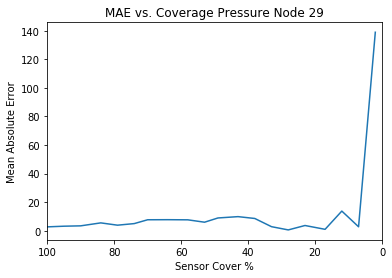

In [6]:
plt.plot(sensors_covered, maximum_MAE)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressure Node 29")
plt.xlim([100, 0])
plt.show()

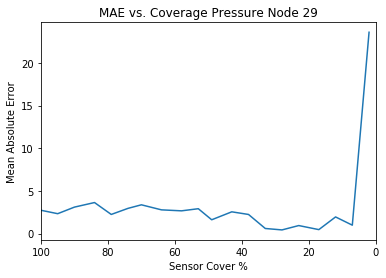

In [7]:
plt.plot(sensors_covered, MAE_average)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressure Node 29")
plt.xlim([100, 0])
plt.show()